In [15]:
!pip install -U scikit-learn



   ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
    --------------------------------------- 0.1/11.0 MB 4.3 MB/s eta 0:00:03
   --- ------------------------------------ 1.1/11.0 MB 11.3 MB/s eta 0:00:01
   --------- ------------------------------ 2.6/11.0 MB 16.9 MB/s eta 0:00:01
   -------------- ------------------------- 3.9/11.0 MB 18.9 MB/s eta 0:00:01
   ------------------ --------------------- 5.0/11.0 MB 20.1 MB/s eta 0:00:01
   ---------------------- ----------------- 6.3/11.0 MB 20.0 MB/s eta 0:00:01
   --------------------------- ------------ 7.5/11.0 MB 20.8 MB/s eta 0:00:01
   ------------------------------- -------- 8.7/11.0 MB 21.4 MB/s eta 0:00:01
   ----------------------------------- ---- 9.9/11.0 MB 22.5 MB/s eta 0:00:01
   ---------------------------------------  11.0/11.0 MB 25.2 MB/s eta 0:00:01
   ---------------------------------------- 11.0/11.0 MB 23.3 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: s

  You can safely remove it manually.

[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Procrustes Alignment Results:
Mean Squared Error (Procrustes): 1.2098153910522873e-05
Mean Correlation (Procrustes): 0.9742120789685623
Affine Transformation Alignment Results:
Mean Squared Error (Affine): 13.740105832389425
Mean Correlation (Affine): 0.9769839180363142
Transformation Matrix (Affine):
[[-1.17087554e+00 -1.10973958e-03 -5.98013286e-02  3.25910336e+00]
 [ 2.38299098e-02 -1.18687105e+00 -1.28840850e-01  4.93136555e+01]
 [ 6.70450181e-02  1.78858042e-01 -1.14742732e+00 -3.44388622e+01]
 [ 6.32283492e-19  1.21430643e-17 -3.56430598e-18  1.00000000e+00]]


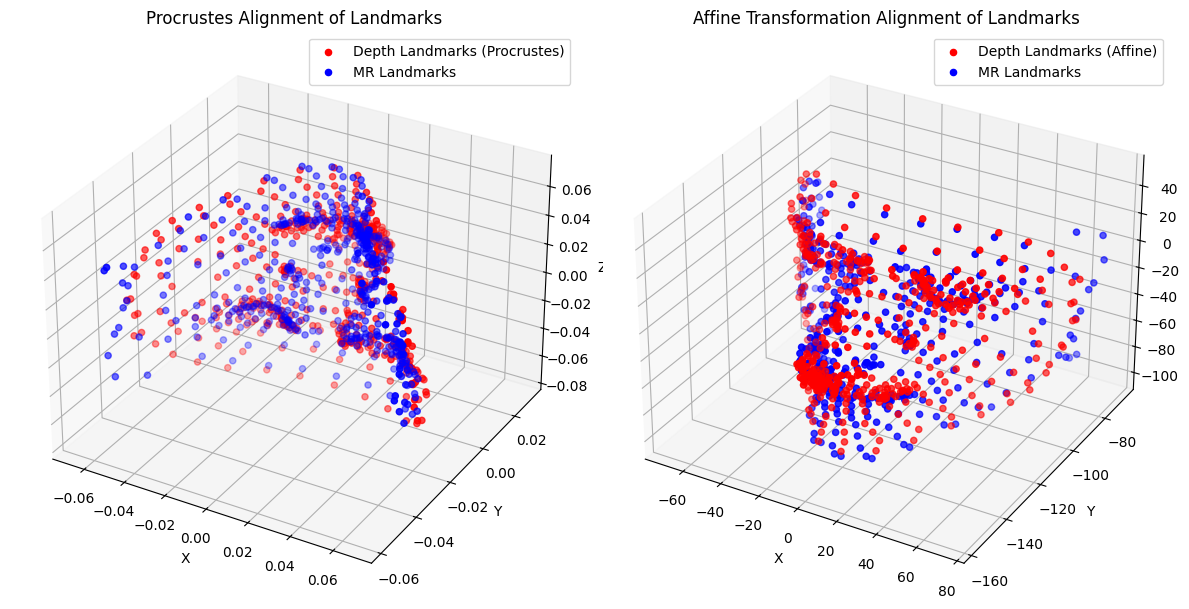

In [5]:
import numpy as np
import csv
from scipy.spatial import procrustes
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.linalg import svd

# Function to read landmarks from a CSV file
def read_landmarks(filename):
    landmarks = []
    with open(filename, 'r') as csvfile:
        csvreader = csv.reader(csvfile)
        next(csvreader)  # Skip header
        for row in csvreader:
            landmarks.append([float(coord) for coord in row])
    return np.array(landmarks)

# Function to compute the transformation matrix using Affine Transformation
def compute_affine_transformation_matrix(A, B):
    # Add a column of ones to A and B for affine transformation
    A_augmented = np.hstack([A, np.ones((A.shape[0], 1))])
    B_augmented = np.hstack([B, np.ones((B.shape[0], 1))])
    
    # Solve for transformation matrix using least squares
    T_affine, _, _, _ = np.linalg.lstsq(A_augmented, B_augmented, rcond=None)
    
    return T_affine.T  # Transpose to get the correct transformation matrix

# Read landmarks from both CSV files (depth and MR)
landmarks_depth = read_landmarks('landmarksdepth.csv')
landmarks_mr = read_landmarks('landmarksmr.csv')

# Extract 3D coordinates
landmarks_depth_3d = landmarks_depth[:, 2:]
landmarks_mr_3d = landmarks_mr[:, 2:]

# Align the landmarks using Procrustes analysis as a baseline
mtx1, mtx2, disparity = procrustes(landmarks_depth_3d, landmarks_mr_3d)

# Calculate mean squared error (MSE) for Procrustes alignment
mse_procrustes = mean_squared_error(mtx1, mtx2)

# Calculate correlation for each coordinate axis for Procrustes alignment
correlations_procrustes = [pearsonr(mtx1[:, i], mtx2[:, i])[0] for i in range(3)]
mean_correlation_procrustes = np.mean(correlations_procrustes)

# Compute the transformation matrix using Affine Transformation
T_affine = compute_affine_transformation_matrix(landmarks_depth_3d, landmarks_mr_3d)

# Apply the transformation to the depth landmarks
landmarks_depth_3d_h = np.hstack((landmarks_depth_3d, np.ones((landmarks_depth_3d.shape[0], 1))))
aligned_depth_affine = (T_affine @ landmarks_depth_3d_h.T).T[:, :-1]

# Calculate mean squared error (MSE) for Affine alignment
mse_affine = mean_squared_error(aligned_depth_affine, landmarks_mr_3d)

# Calculate correlation for each coordinate axis for Affine alignment
correlations_affine = [pearsonr(aligned_depth_affine[:, i], landmarks_mr_3d[:, i])[0] for i in range(3)]
mean_correlation_affine = np.mean(correlations_affine)

# Visualize the aligned landmarks using Procrustes analysis and Affine Transformation
fig = plt.figure(figsize=(12, 6))

ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(mtx1[:, 0], mtx1[:, 1], mtx1[:, 2], color='r', label='Depth Landmarks (Procrustes)')
ax1.scatter(mtx2[:, 0], mtx2[:, 1], mtx2[:, 2], color='b', label='MR Landmarks')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.set_title('Procrustes Alignment of Landmarks')
ax1.legend()

ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(aligned_depth_affine[:, 0], aligned_depth_affine[:, 1], aligned_depth_affine[:, 2], color='r', label='Depth Landmarks (Affine)')
ax2.scatter(landmarks_mr_3d[:, 0], landmarks_mr_3d[:, 1], landmarks_mr_3d[:, 2], color='b', label='MR Landmarks')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
ax2.set_title('Affine Transformation Alignment of Landmarks')
ax2.legend()

# Print the error metrics and transformation matrix for Affine alignment
print("Procrustes Alignment Results:")
print(f"Mean Squared Error (Procrustes): {mse_procrustes}")
print(f"Mean Correlation (Procrustes): {mean_correlation_procrustes}")

print("Affine Transformation Alignment Results:")
print(f"Mean Squared Error (Affine): {mse_affine}")
print(f"Mean Correlation (Affine): {mean_correlation_affine}")
print("Transformation Matrix (Affine):")
print(T_affine)

plt.tight_layout()
plt.show()
